In [51]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython.display as ipd
import warnings
import soundfile as sf
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


| **Aspect**       | **Bonafide**                                   | **Tacotron**                                                                 | **VITS**                                                                                  |
|-------------------|-----------------------------------------------|------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| **Definition**    | Genuine human speech recordings               | Neural network-based TTS model                                              | Advanced TTS model with variational inference and adversarial training                   |
| **Purpose**       | Reference or ground truth                    | Produces natural-sounding speech, requires vocoder                          | Generates high-quality, expressive, and emotional speech                                 |
| **Technology**    | Real human recordings                        | Sequence-to-sequence architecture, text to mel-spectrogram                  | Combines variational inference and adversarial training for high-quality speech          |
| **Expressiveness**| Natural, but limited to real recordings       | Produces natural-sounding speech with basic expressiveness                  | High-quality speech with a wide range of emotions and speaking styles                    |


In [71]:
dir = 'deepfake_detection_dataset_urdu'
classes = ["Bonafide", "Spoofed_Tacotron", "Spoofed_TTS"] 
speakers = [f"Speaker_{i:02d}" for i in range(1, 18)]
print (speakers)

['Speaker_01', 'Speaker_02', 'Speaker_03', 'Speaker_04', 'Speaker_05', 'Speaker_06', 'Speaker_07', 'Speaker_08', 'Speaker_09', 'Speaker_10', 'Speaker_11', 'Speaker_12', 'Speaker_13', 'Speaker_14', 'Speaker_15', 'Speaker_16', 'Speaker_17']


In [74]:
def load_audio(dir, classes, speakers):
    data = []
    for classname in classes:
        class_path = os.path.join(dir, classname)
        if not os.path.exists(class_path):
            print(f"Directory {class_path} does not exist")
            continue
        for speaker in speakers:
            speaker_path = os.path.join(class_path, speaker)
            if not os.path.exists(speaker_path):
                print(f"Speaker directory missing: {speaker_path}")
                continue
            
            if classname == "Bonafide":
                for part in ['Part 1', 'Part 2']:
                    part_path = os.path.join(speaker_path, part)
                    if os.path.exists(part_path):
                        for file in os.listdir(part_path):
                            if file.endswith('.wav'): 
                                file_path = os.path.join(part_path, file)
                                sr = librosa.get_samplerate(file_path)
                                duration = librosa.get_duration(filename=file_path)
                                data.append({
                                "path": file_path,
                                "class": classname,
                                "speaker": speaker,
                                "original_sr": sr,
                                "duration": duration
                            })
                            else:
                                print(f"Skipping non-wav file: {file}")
            else:
                for file in os.listdir(speaker_path):
                    if file.endswith('.wav'):  
                        file_path = os.path.join(speaker_path, file)
                        sr = librosa.get_samplerate(file_path)
                        duration = librosa.get_duration(filename=file_path)
                        data.append({
                        "path": file_path,
                        "class": classname,
                        "speaker": speaker,
                        "original_sr": sr,
                        "duration": duration
                    })
                    else:
                        print(f"Skipping non-wav file: {file}")

    return pd.DataFrame(data)

df=load_audio(dir,classes,speakers)
print("Total number of files: ",len(df))

Total number of files:  6794


In [75]:
df.head(10)

,path,class,speaker,original_sr,duration
0,deepfake_detection_dataset_urdu/Bonafide/Speak...,Bonafide,Speaker_01,16000,8.086000
1,deepfake_detection_dataset_urdu/Bonafide/Speak...,Bonafide,Speaker_01,16000,4.488188
2,deepfake_detection_dataset_urdu/Bonafide/Speak...,Bonafide,Speaker_01,16000,5.346063
3,deepfake_detection_dataset_urdu/Bonafide/Speak...,Bonafide,Speaker_01,16000,8.854938
4,deepfake_detection_dataset_urdu/Bonafide/Speak...,Bonafide,Speaker_01,16000,4.559750
5,deepfake_detection_dataset_urdu/Bonafide/Speak...,Bonafide,Speaker_01,16000,8.528000
6,deepfake_detection_dataset_urdu/Bonafide/Speak...,Bonafide,Speaker_01,16000,8.687188
7,deepfake_detection_dataset_urdu/Bonafide/Speak...,Bonafide,Speaker_01,16000,10.186938
8,deepfake_detection_dataset_urdu/Bonafide/Speak...,Bonafide,Speaker_01,16000,5.002813
9,deepfake_detection_dataset_urdu/Bonafide/Speak...,Bonafide,Speaker_01,16000,9.334000


In [76]:
df['class'].value_counts()

class
Bonafide            3398
Spoofed_Tacotron    1698
Spoofed_TTS         1698
Name: count, dtype: int64

### **Exploratory Data Analysis (EDA)**

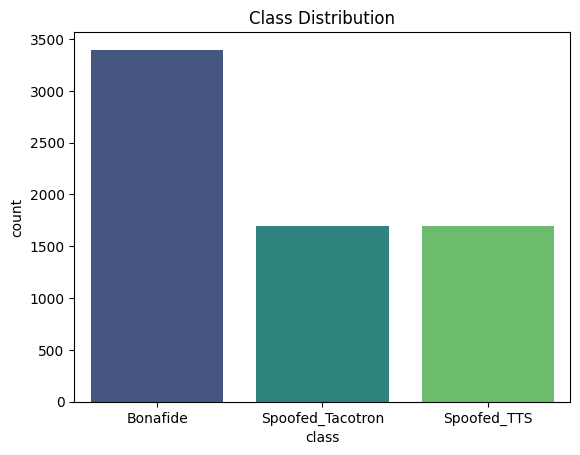

In [77]:
sns.countplot(data=df, x='class', palette='viridis')
plt.title('Class Distribution')
plt.show()

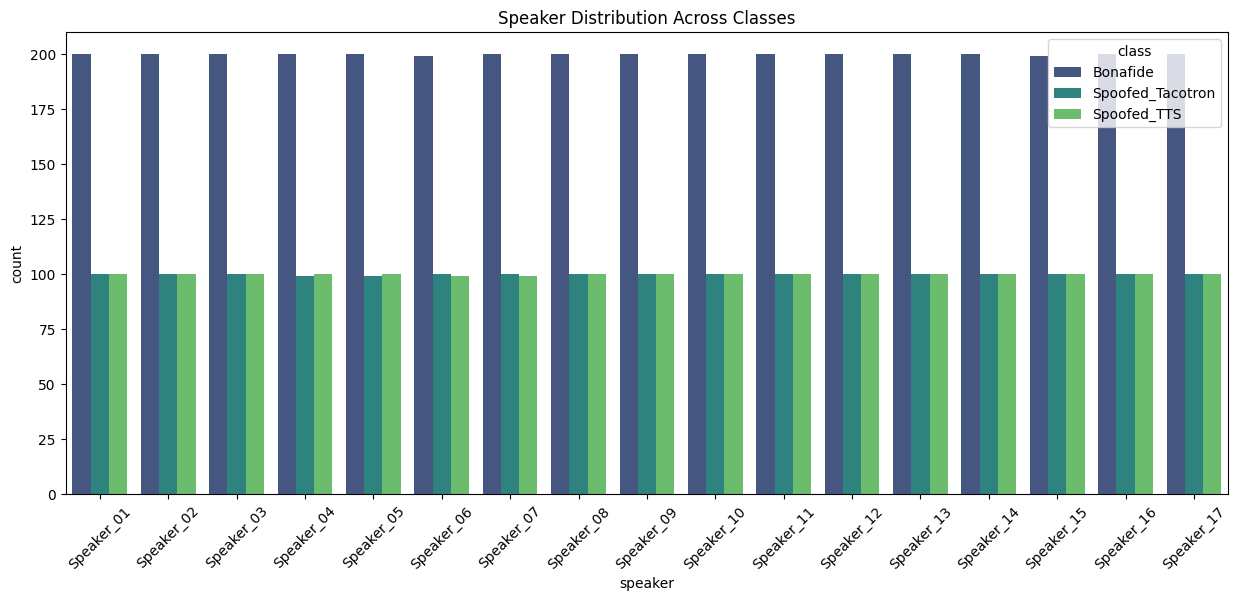

In [78]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x="speaker", hue="class", palette="viridis")
plt.title("Speaker Distribution Across Classes")
plt.xticks(rotation=45)
plt.show()

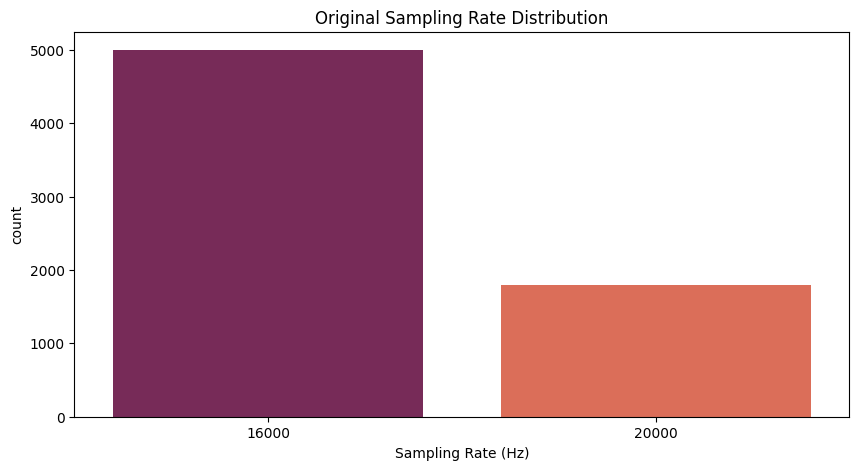

In [79]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="original_sr", palette="rocket")
plt.title("Original Sampling Rate Distribution")
plt.xlabel("Sampling Rate (Hz)")
plt.show()


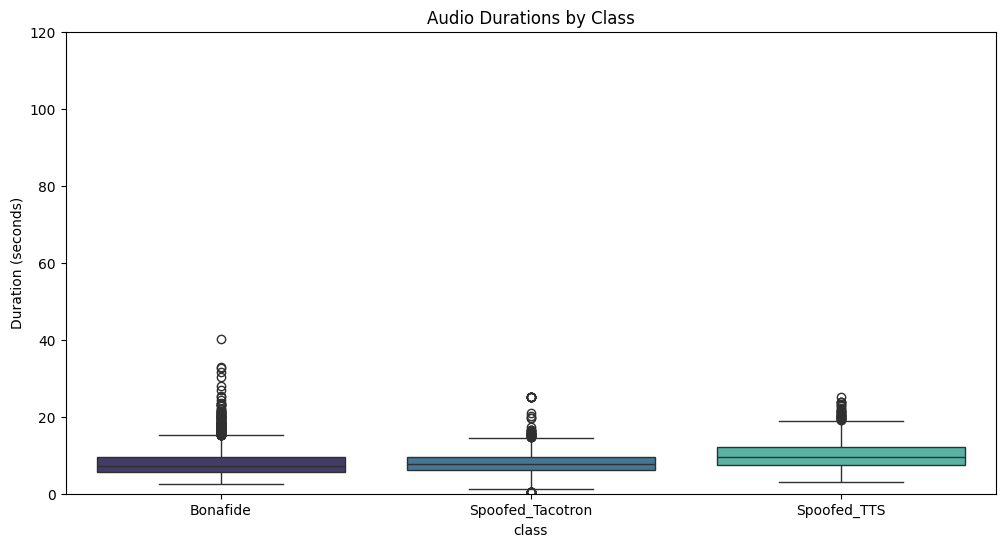

In [80]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="class", y="duration", palette="mako")
plt.title("Audio Durations by Class")
plt.ylabel("Duration (seconds)")
plt.ylim(0, 120)  # Adjust based on your data
plt.show()

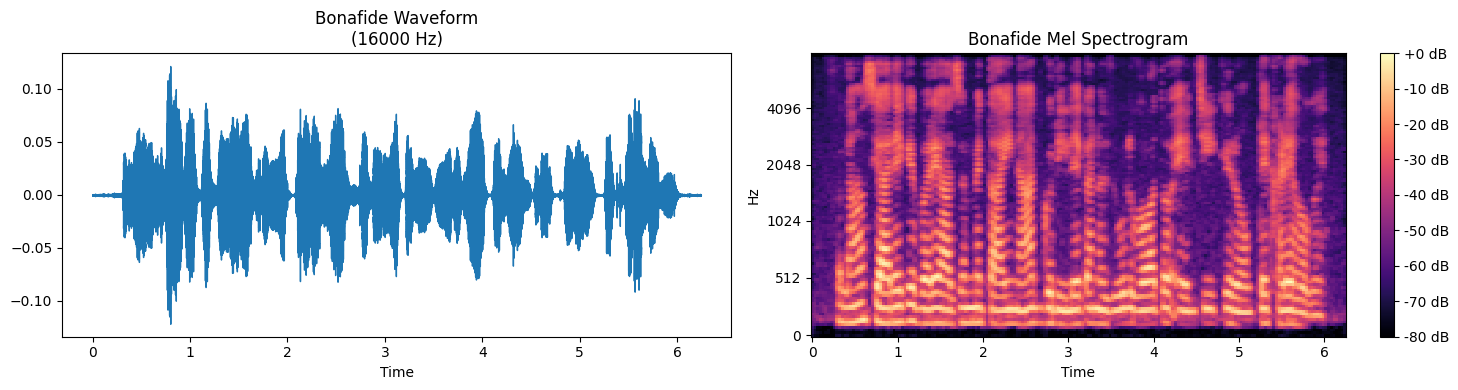

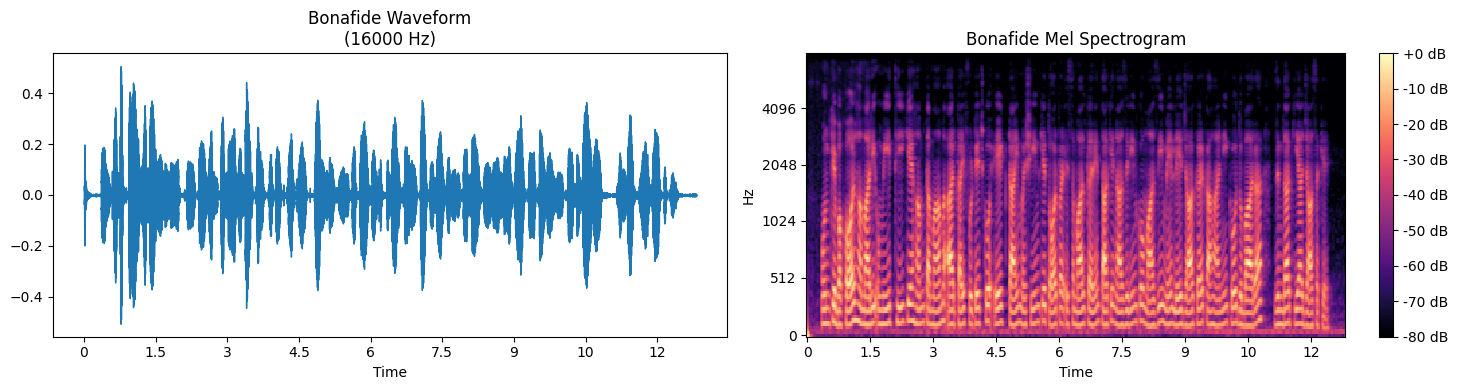

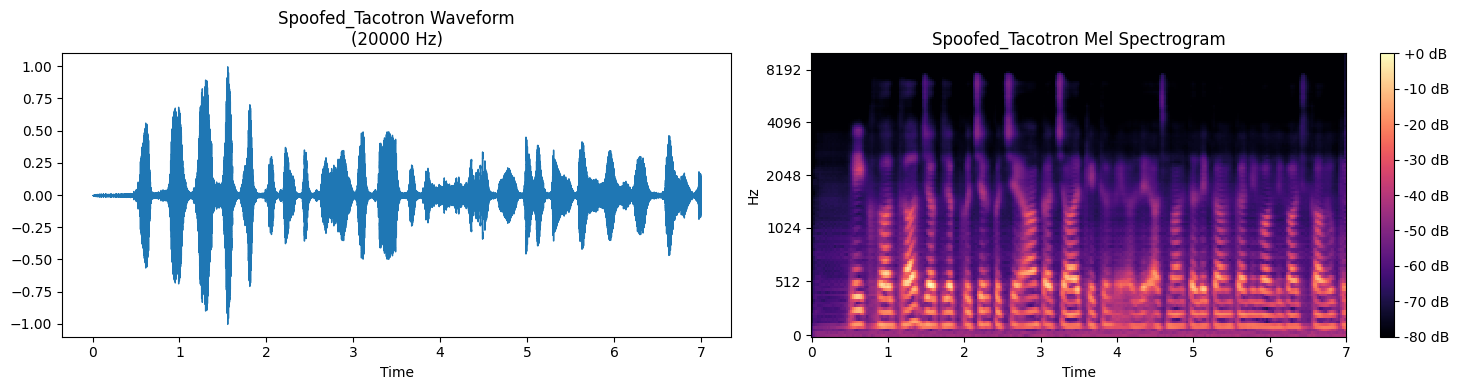

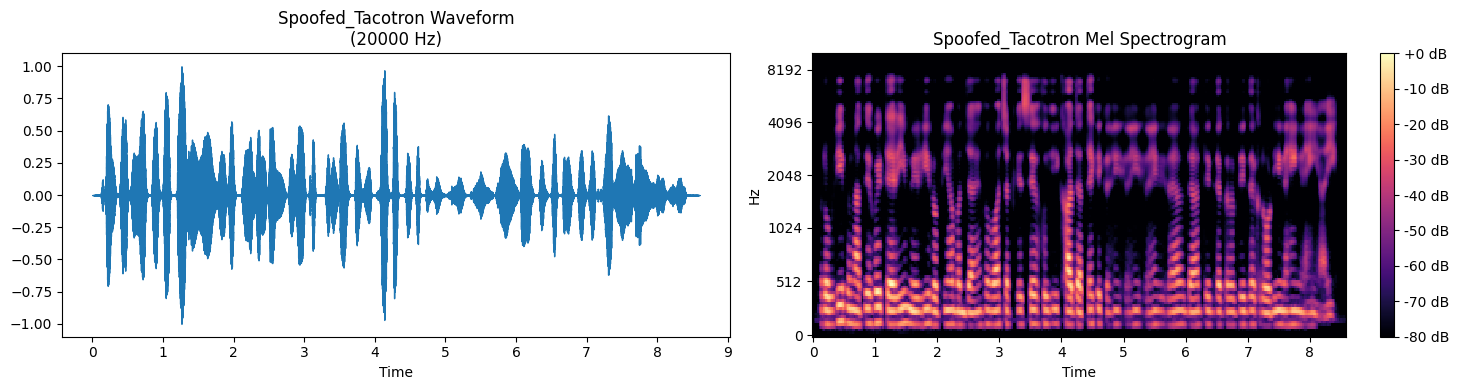

In [82]:
def plot_audio_samples(df, class_name, n_samples=2):
    """Plot waveforms and spectrograms for a class."""
    sample_files = df[df["class"] == class_name].sample(n_samples, random_state=42)
    
    for idx, row in sample_files.iterrows():
        audio, sr = librosa.load(row["path"], sr=None)
        plt.figure(figsize=(15, 4))
        
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f"{class_name} Waveform\n({sr} Hz)")
        
        plt.subplot(1, 2, 2)
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis="time", y_axis="mel")
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"{class_name} Mel Spectrogram")
        
        plt.tight_layout()
        plt.show()

plot_audio_samples(df, "Bonafide")
plot_audio_samples(df, "Spoofed_Tacotron")


In [83]:
df.to_csv('deepfake_dataset.csv', index=False)

In [87]:
def get_sampling_rate(file_path):
    try:
        return librosa.get_samplerate(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

df_sample = df.sample(10, random_state=42)
df_sample["sampling_rate"] = df_sample["path"].apply(get_sampling_rate)
print(df_sample[["path", "sampling_rate"]])

                                                   path  sampling_rate
3480  deepfake_detection_dataset_urdu/Spoofed_Tacotr...          20000
4093  deepfake_detection_dataset_urdu/Spoofed_Tacotr...          20000
5904  deepfake_detection_dataset_urdu/Spoofed_TTS/Sp...          16000
3535  deepfake_detection_dataset_urdu/Spoofed_Tacotr...          20000
6507  deepfake_detection_dataset_urdu/Spoofed_TTS/Sp...          16000
5551  deepfake_detection_dataset_urdu/Spoofed_TTS/Sp...          16000
3454  deepfake_detection_dataset_urdu/Spoofed_Tacotr...          20000
1183  deepfake_detection_dataset_urdu/Bonafide/Speak...          16000
4765  deepfake_detection_dataset_urdu/Spoofed_Tacotr...          20000
132   deepfake_detection_dataset_urdu/Bonafide/Speak...          16000


In [88]:
SR = 16000
def resample_audio(audio, original_sr, target_sr=SR):
    """Resample audio to target sampling rate."""
    return librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)


In [89]:
def trim_silence(audio, top_db=20):
    """Remove leading/trailing silence."""
    return librosa.effects.trim(audio, top_db=top_db)[0]

In [90]:
seg_len=3
def split_audio(audio, sr=SR, segment_length=seg_len):
    """Split audio into fixed-length segments."""
    samples_per_segment = sr * segment_length
    if len(audio) < samples_per_segment:
        # Pad short files
        audio = np.pad(audio, (0, samples_per_segment - len(audio)))
    return [
        audio[i:i+samples_per_segment] 
        for i in range(0, len(audio), samples_per_segment)
    ]

In [99]:
def process_file(input_path, output_dir, row):
    """Preprocess audio and save with structured filenames."""
    try:
        # Load with native sampling rate
        audio, original_sr = librosa.load(input_path, sr=None)
        
        # Resample to target SR
        audio = librosa.resample(audio, orig_sr=original_sr, target_sr=SR)
        
        # Trim silence
        audio, _ = librosa.effects.trim(audio, top_db=20)
        
        # Split into segments
        segments = split_audio(audio, sr=SR, segment_length=seg_len)
        
        # Extract metadata from the original row
        class_name = row["class"]
        speaker = row["speaker"]
        original_file_id = os.path.splitext(os.path.basename(input_path))[0]  # e.g., "317"
        
        # Save segments with structured filenames
        saved_paths = []
        for i, segment in enumerate(segments):
            # Format: Bonafide_Speaker_01_317_seg0.wav
            output_filename = f"{class_name}_{speaker}_{original_file_id}_seg{i}.wav"
            output_path = os.path.join(output_dir, output_filename)
            sf.write(output_path, segment, SR)
            saved_paths.append(output_path)
        
        return saved_paths
    
    except Exception as e:
        print(f"Error processing {input_path}: {str(e)}")
        return []


In [100]:
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

processed_files = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    saved_paths = process_file(row["path"], output_dir, row)  # Pass the row data
    processed_files.extend(saved_paths)

print(f"\nTotal processed segments: {len(processed_files)}")


Processing: 100%|██████████| 6794/6794 [14:16<00:00,  7.93it/s]


Total processed segments: 20726


In [102]:
def parse_processed_filename(filename):
    """Extract class, speaker, and original file ID from filenames."""
    parts = os.path.splitext(filename)[0].split("_")
    # Format: [Bonafide, Speaker_01, 317, seg0]
    class_name = parts[0]
    speaker = "_".join(parts[1:3])  # Handle "Speaker_01"
    original_file_id = parts[3]
    return class_name, speaker, original_file_id

In [104]:
metadata = []
for file in processed_files:
    filename = os.path.basename(file)
    class_name, speaker, original_file_id = parse_processed_filename(filename)
    metadata.append({
        "file_path": file,
        "class": class_name,
        "speaker": speaker,
        "original_file_id": original_file_id
    })

processed_df = pd.DataFrame(metadata)
processed_df.to_csv("processed_deepfake_urdu.csv", index=False)

In [108]:
for file in processed_files[5:10]:
    audio, sr = librosa.load(file, sr=SR)
    print("Audio :",audio)
    print("SR :",sr)
    print(f"{os.path.basename(file)}: {len(audio)/SR:.2f} seconds, SR={sr}")


Audio : [0.00097656 0.00109863 0.00106812 ... 0.0942688  0.08413696 0.08010864]
SR : 16000
Bonafide_Speaker_01_260_seg0.wav: 3.00 seconds, SR=16000
Audio : [ 0.11251831  0.081604    0.09521484 ... -0.00790405 -0.00531006
 -0.00189209]
SR : 16000
Bonafide_Speaker_01_260_seg1.wav: 3.00 seconds, SR=16000
Audio : [ 3.0517578e-05  2.1362305e-04 -9.1552734e-05 ...  2.9846191e-02
 -1.4221191e-02 -5.7495117e-02]
SR : 16000
Bonafide_Speaker_01_671_seg0.wav: 3.00 seconds, SR=16000
Audio : [-0.08084106 -0.04959106 -0.04092407 ...  0.01849365 -0.00448608
  0.01977539]
SR : 16000
Bonafide_Speaker_01_671_seg1.wav: 3.00 seconds, SR=16000
Audio : [ 0.02453613 -0.01062012  0.00494385 ... -0.00350952 -0.00289917
 -0.00231934]
SR : 16000
Bonafide_Speaker_01_671_seg2.wav: 0.78 seconds, SR=16000


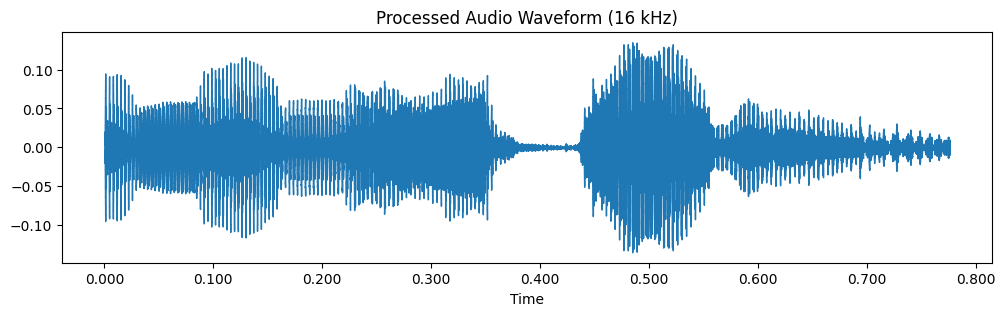

In [105]:
plt.figure(figsize=(12, 3))
librosa.display.waveshow(audio, sr=SR)
plt.title("Processed Audio Waveform (16 kHz)")
plt.show()


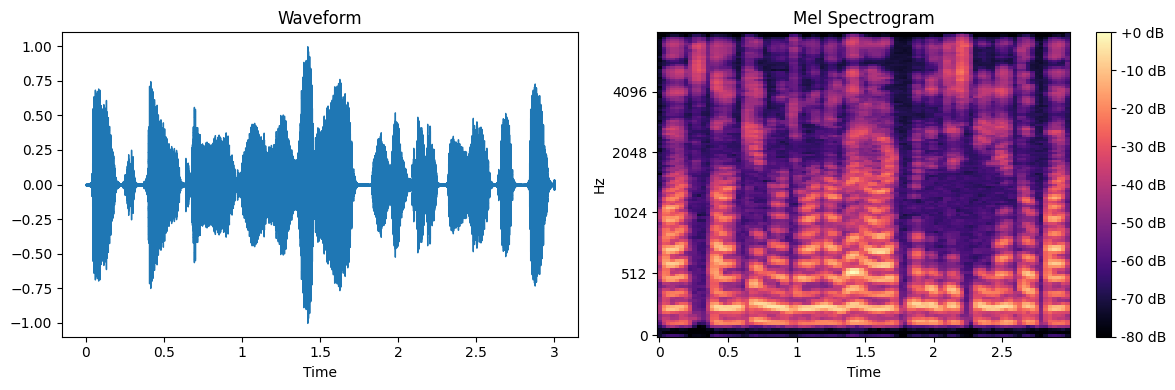

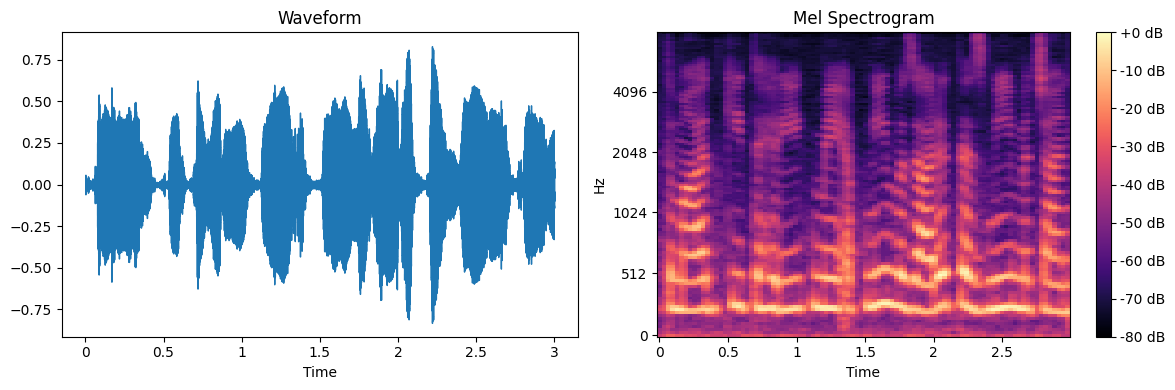

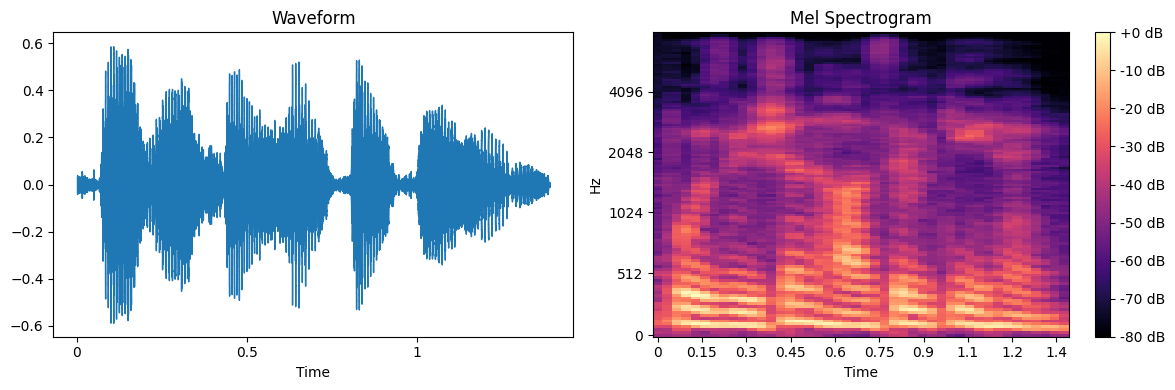

In [106]:
def plot_processed_samples(output_dir, n_samples=3):
    """Verify processed files visually."""
    processed_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir)][:n_samples]
    
    for file in processed_files:
        audio, sr = librosa.load(file, sr=SR)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(audio, sr=sr)
        plt.title("Waveform")
        
        plt.subplot(1, 2, 2)
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis="time", y_axis="mel")
        plt.colorbar(format="%+2.0f dB")
        plt.title("Mel Spectrogram")
        
        plt.tight_layout()
        plt.show()

plot_processed_samples(output_dir)

In [109]:
print(processed_df.head())

print(processed_df["class"].value_counts())

                                         file_path     class     speaker  \
0  processed_data/Bonafide_Speaker_01_317_seg0.wav  Bonafide  Speaker_01   
1  processed_data/Bonafide_Speaker_01_317_seg1.wav  Bonafide  Speaker_01   
2  processed_data/Bonafide_Speaker_01_317_seg2.wav  Bonafide  Speaker_01   
3  processed_data/Bonafide_Speaker_01_707_seg0.wav  Bonafide  Speaker_01   
4  processed_data/Bonafide_Speaker_01_707_seg1.wav  Bonafide  Speaker_01   

  original_file_id  
0              317  
1              317  
2              317  
3              707  
4              707  
class
Spoofed     10626
Bonafide    10100
Name: count, dtype: int64
